# CAB420, Clustering, Additional Example: Comparing Clustering Methods
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* ~~There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.~~ Actually, there is a TL;DR section here as I've moved this from the main content into the bonus content.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.


## Overview
Let's now look at the four clustering methods side by side. We'll use the NY taxi data, and constrain ourselves to JFK airport. We'll also look at two applications:
* Visualisation/Knoweldge Discovery; and
* anomaly detection.
And see how well each method works for each.

This is, to a large extent, a revist of the fourth example from last week that explored the new york citibike data, but we're now adding HAC and DBScan into the mix.

### Too Long; Didn't Read:
* All four methods can be used to visualise data, and analyse patterns, do knowledge discovery, etc. Though choices in model parameters will impact what is observed and possibly what conclusions are reached
* GMMs are able to capture different densities and different shapes compared to our other methods, and HAC can yield some odd results if different linkage criteria are used. DBScan can separate noise from the rest of the data (btu can be hard to tune).
* For anomaly detection, the ability to measure how far a point is from something (like a distribution, or a cluster centre) is key. This means that HAC and DBScan are very hard to deploy here. 
* The ability of GMMs to model liklihood makes them well suited to anomaly detections tasks. We can (sort of) approximate this with K-means and the distance to the cluster centre, however this tends to just find points at cluster boundaries

### Where does this fit into all the other CAB420 content?

This was once an additional example that provided another side-by-side comparison of the four clustering methods. It simply wraps up the core and bonus classification content, and alongside the diarisation example provides a comparison of the various methods.

In [2]:
import pandas
import numpy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib import cm
from datetime import datetime
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import hdbscan

## PART 1: Load the data
We're using just a single day of data. Note that NY taxis come in two flavours:
* Green, which are trips that start outside of Manhattan
* Yellow, which are trips that start within Manhattan

We're going to grab both and combine them. Note that there are slight differences in the table format for the two sets of taxis. To work around this, we'll
* load the two sets
* pull out the columns that we want
* find trips that end at JFK airport
* and grab just those to cluster

In [3]:
green = pandas.read_csv('../data/NYTaxis/2016_Green_Taxi_Trip_Data.csv'); 
yellow = pandas.read_csv('../data/NYTaxis/2016_Yellow_Taxi_Trip_Data.csv');
green = green[['Lpep_dropoff_datetime', 'Dropoff_longitude', 'Dropoff_latitude']]
yellow = yellow[['tpep_pickup_datetime', 'dropoff_longitude', 'dropoff_latitude']]
green = green.rename(columns={'Lpep_dropoff_datetime':'time', 'Dropoff_longitude':'lon', 'Dropoff_latitude':'lat'})
yellow = yellow.rename(columns={'tpep_pickup_datetime':'time', 'dropoff_longitude':'lon', 'dropoff_latitude':'lat'})
taxis = pandas.concat([green, yellow])
taxis = taxis[(taxis['lon'] >= -73.805) & (taxis['lon'] <= -73.765) & (taxis['lat'] >= 40.636) & (taxis['lat'] <= 40.656)]
taxis = taxis.reset_index()
taxis['time'] = pandas.to_datetime(taxis['time']) 
print(taxis.info())

# in this example, I'm pulling this out in an array to reduce some typing
X = numpy.array(taxis[['lon', 'lat']])

morning = [((t.hour >= 6) & (t.hour < 9)) for t in taxis['time']]
evening = [((t.hour >= 18) & (t.hour < 21)) for t in taxis['time']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3205 entries, 0 to 3204
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   3205 non-null   int64         
 1   time    3205 non-null   datetime64[ns]
 2   lon     3205 non-null   float64       
 3   lat     3205 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 100.3 KB
None


## Application 1: Visualisation

### With K-Means
Let's look at a simple application, we want to compare how the JFK terminal is used by taxis at different time periods, and see if there's a noticable different between the morning and evening. Let's start with k-means for now. K-means told us we should have about 200 clusters (see Ex3), so let's do that.

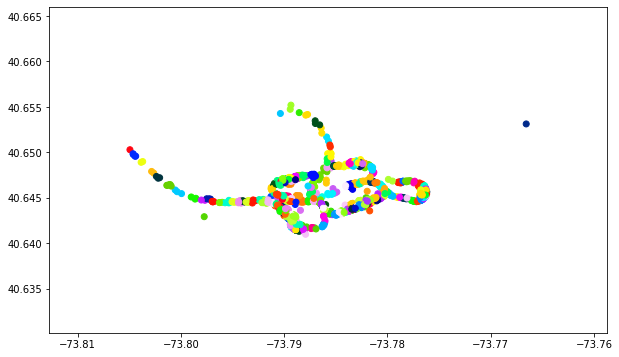

In [4]:
kmeans = KMeans(n_clusters=200, random_state=4).fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap=cm.get_cmap('gist_ncar'));

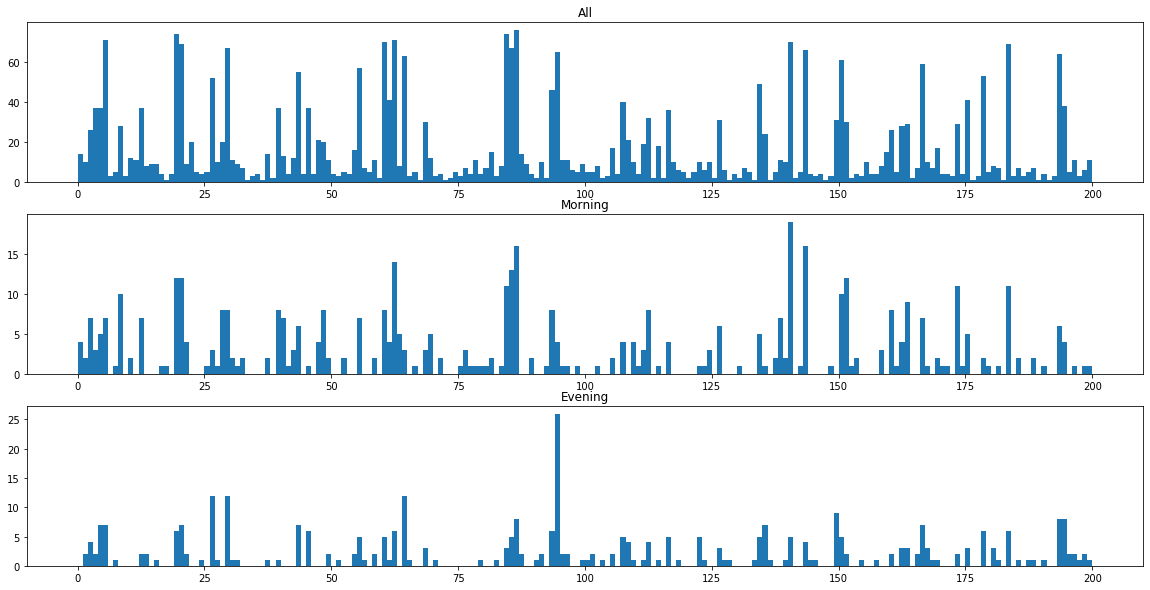

In [5]:
def draw_bars(labels, morning, evening, k):

    bins = list(range(k + 1))
    
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(3, 1, 1)
    ax.hist(labels, bins=bins)
    ax.set_title('All')
    ax = fig.add_subplot(3, 1, 2)
    ax.hist(labels[morning], bins=bins)
    ax.set_title('Morning')
    ax = fig.add_subplot(3, 1, 3)
    ax.hist(labels[evening], bins=bins)
    ax.set_title('Evening')
    
draw_bars(kmeans.labels_, morning, evening, 200)

Personally, I find the above two plots hard to interperet. It's very hard to look at the 200 clusters and make any sense of them. Many of these clusters are also tiny, so they have little actual meaning. Looking at the histgorams, we can see that tiny counts dominate, and patterns are hard to see. Overall, perhaps 200 clusters isn't a good number here.

Our "elbow" method suggested a number around 6-8, but let's use 8 and see what that gives us.

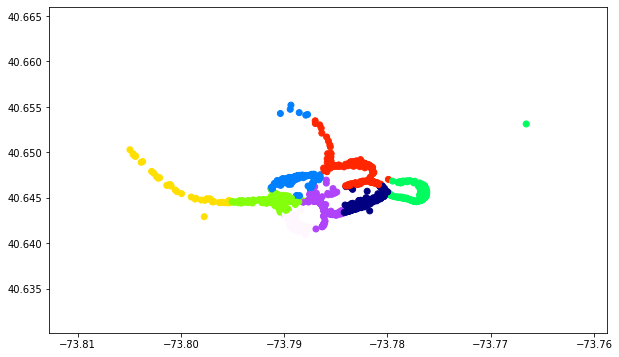

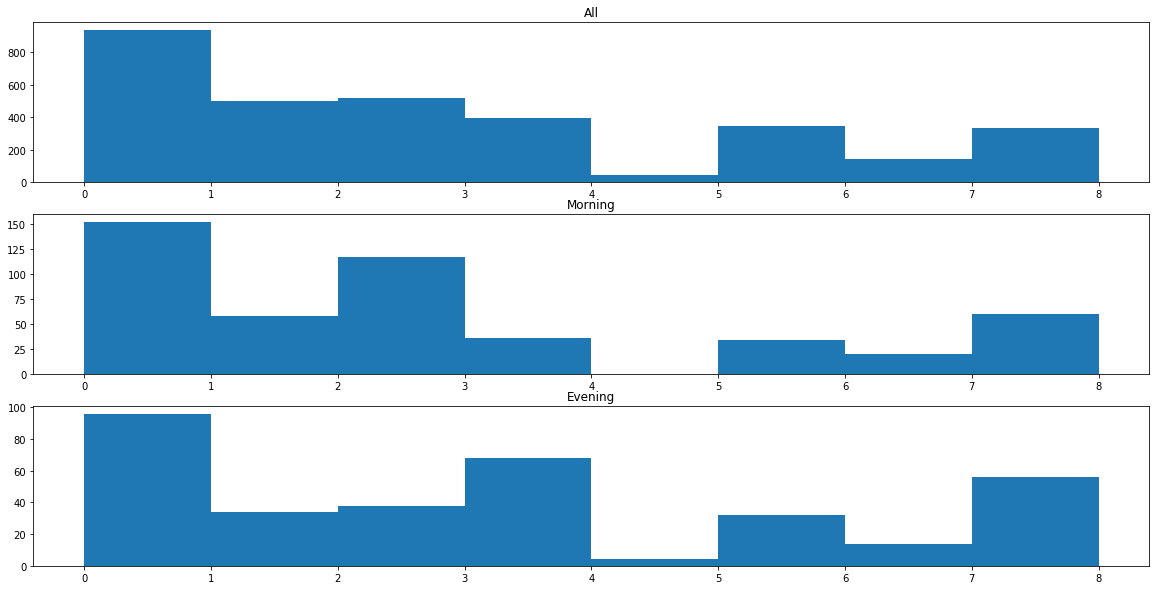

In [6]:
kmeans = KMeans(n_clusters=8, random_state=4).fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap=cm.get_cmap('gist_ncar'));
draw_bars(kmeans.labels_, morning, evening, 8)

This time it's much easier to look at the results. Without doubt we've lost detail, but that may not be an issue here. Most of our clusters contain a fair number of samples, and each could be seen to characterise a behaviour - in this case dropping off at a given locaiton. We can now also see more of a pattern in the data in terms of changes in behvaiour. We can see that both morning and evening deviate from the overall distribution a little bit in different ways, showing distinct behaviours.

On the whole, while this number of clusters may be sub-optimal according to one criteria, it may be more useful depending on our task. 

### With a GMM
We can do this same process with a GMM. We'll consider a K of 10, which was (roughly) or minimum BIC.

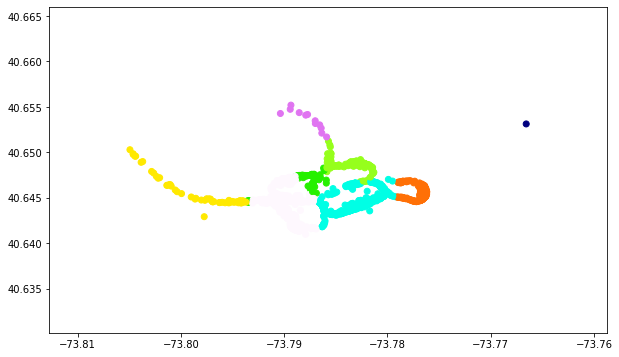

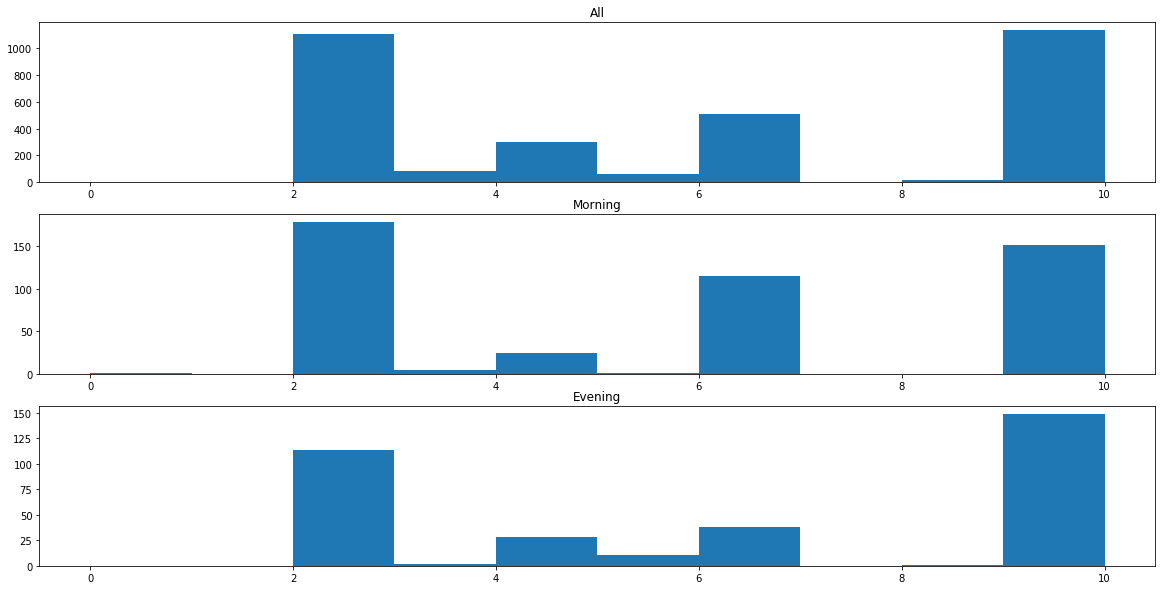

In [7]:
gmm = GaussianMixture(10, random_state=4)
gmm.fit(X)
labels = gmm.predict(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=labels, cmap=cm.get_cmap('gist_ncar'));
draw_bars(labels, morning, evening, 10)

We can see our clustering results are a bit different, but again our conclusion that the morning and evening are both different from the overall is valid.

Keep in mind too that with these results, with a different random seed we'd get different answers. That doesn't mean that these conclusions are wrong, just that we need to be careful drawing concluions from the results

### With HAC
Let's now look at HAC.

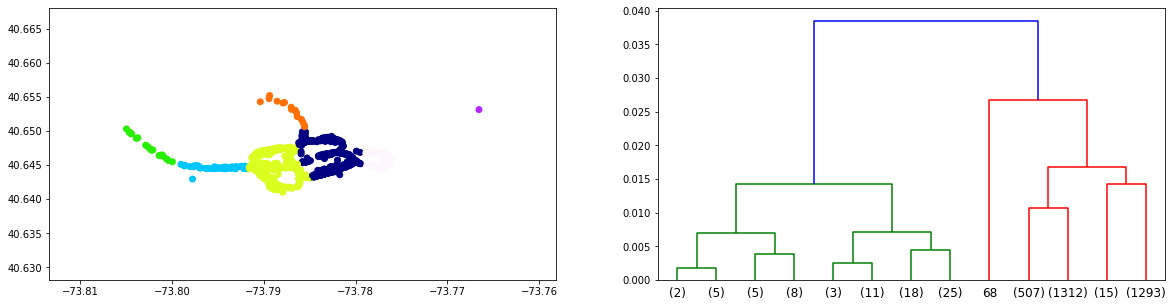

In [8]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
fig = plt.figure(figsize=[20, 5])
hac = AgglomerativeClustering(distance_threshold=0.01, n_clusters=None, linkage='complete', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_, cmap=cm.get_cmap('gist_ncar'));
ax = fig.add_subplot(1, 2, 2)
plot_dendrogram(hac, truncate_mode='level', p=3)

That looks ok. We need to check how many clusters we ended up with.

In [9]:
print(max(hac.labels_))

6


And now we can plot that.

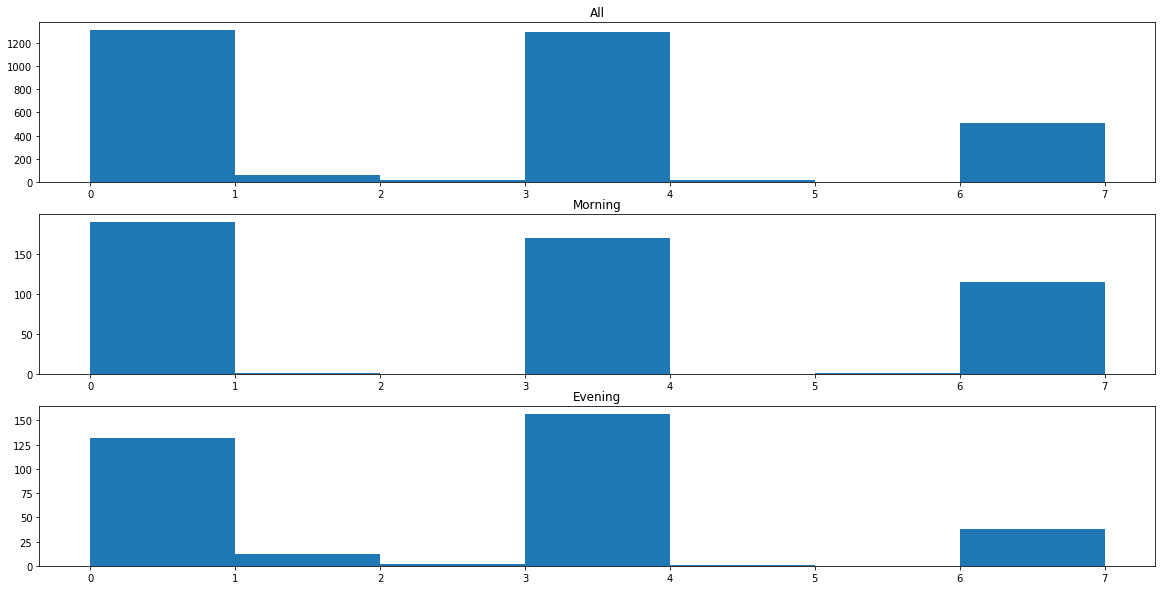

In [10]:
draw_bars(hac.labels_, morning, evening, max(hac.labels_)+1)

That doesn't really show up a lot of differences at all. We can try re-clustering to see if get something closer to what we had before.

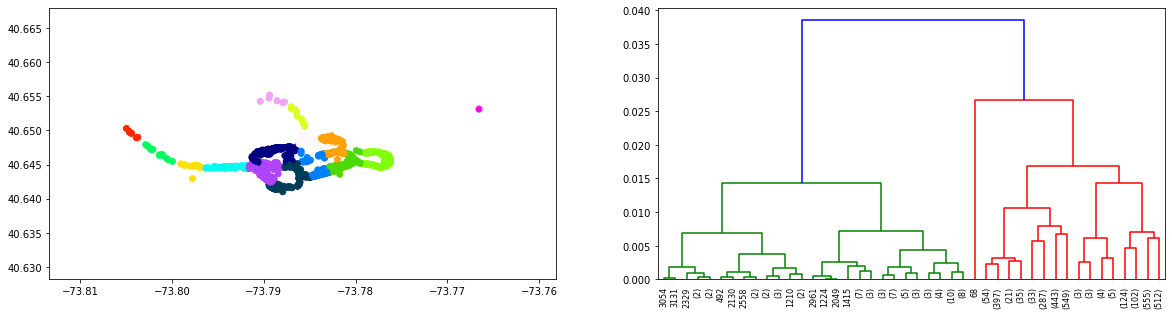

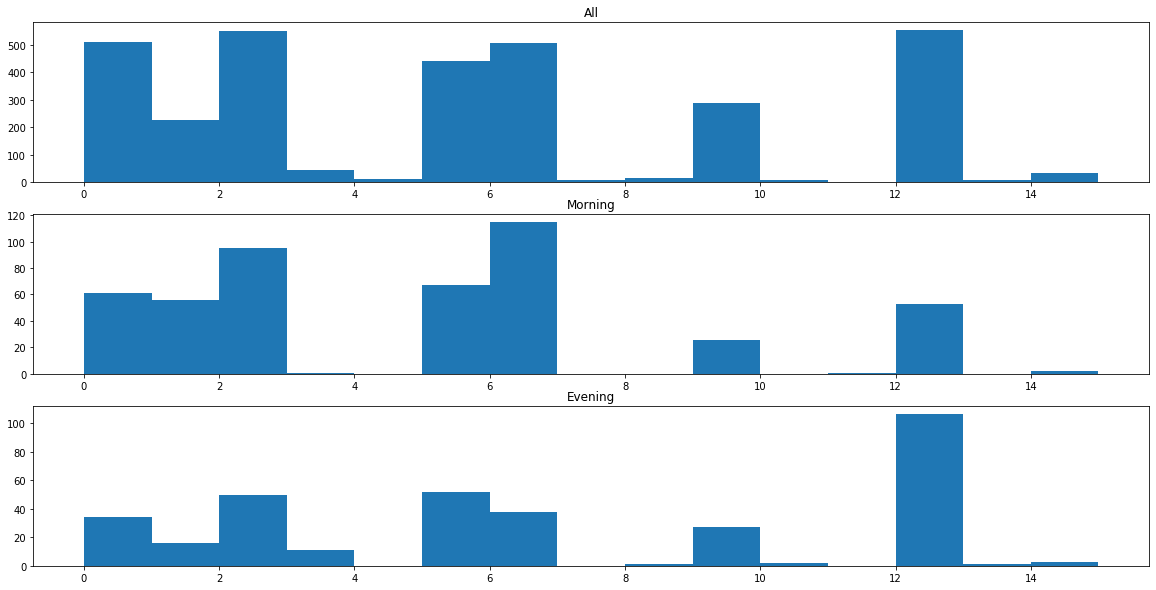

In [11]:
fig = plt.figure(figsize=[20, 5])
hac = AgglomerativeClustering(distance_threshold=0.005, n_clusters=None, linkage='complete', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_, cmap=cm.get_cmap('gist_ncar'));
ax = fig.add_subplot(1, 2, 2)
plot_dendrogram(hac, truncate_mode='level', p=5)
draw_bars(hac.labels_, morning, evening, max(hac.labels_)+1)

This is perhaps doing a better job, and more clearly shows up changes in behaviour. We could get a lot of variation by changing our linkage criterion too.

### With DBScan

Finally, let's give DBScan a go.

We need to set our DBScan hyper parameters, and eps in particular can be a bit tricky. We'll try $0.001$.

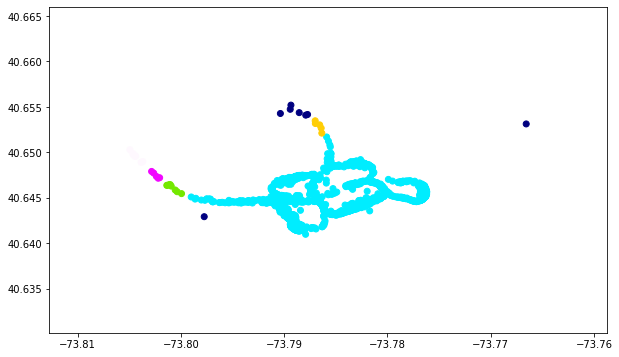

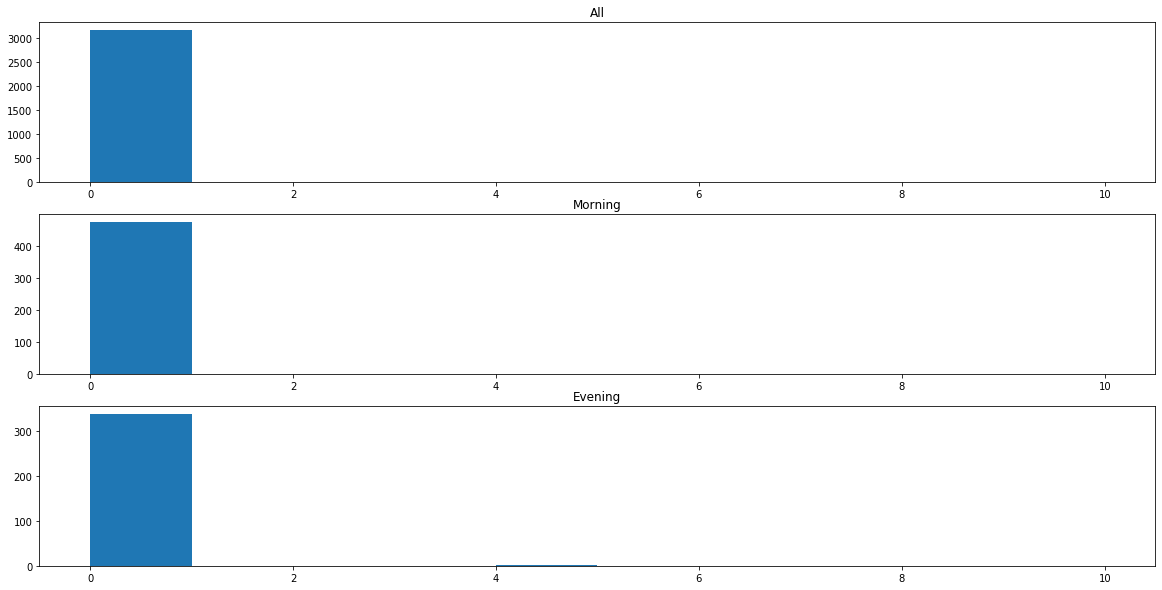

In [12]:
db = DBSCAN(eps=0.001, min_samples=5)
db.fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=db.labels_, cmap=cm.get_cmap('gist_ncar'));
draw_bars(db.labels_, morning, evening, 10)

This puts just about everything in one cluster, which is not of much use. We'll reduce it by a factor of 10 to $0.0001$.

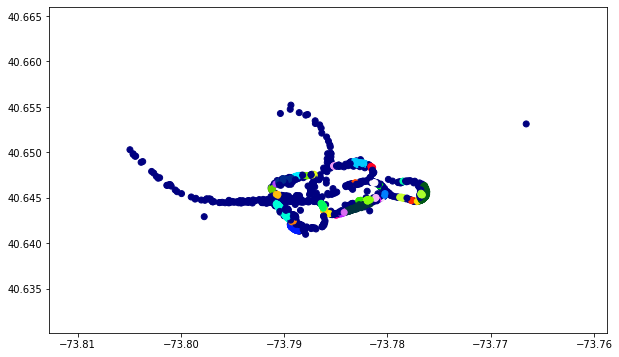

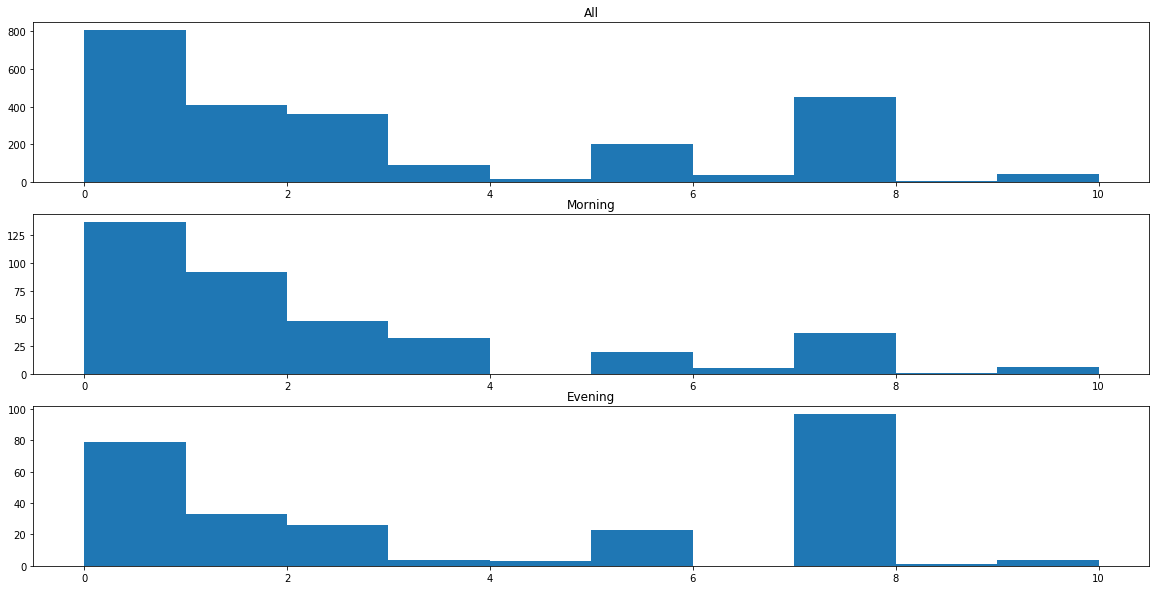

In [13]:
db = DBSCAN(eps=0.0001, min_samples=5)
db.fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=db.labels_, cmap=cm.get_cmap('gist_ncar'));
draw_bars(db.labels_, morning, evening, 10)

This now has most of the data in the "noise" cluster. We'll finally try something in the middle.

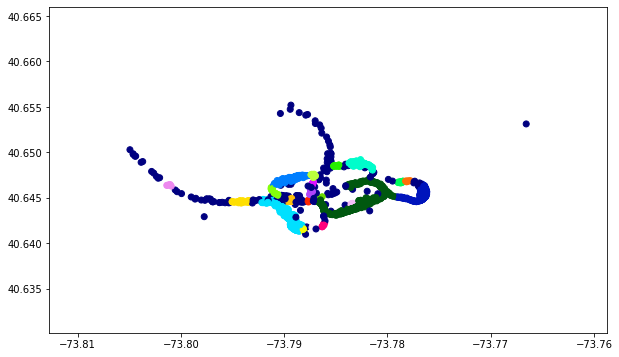

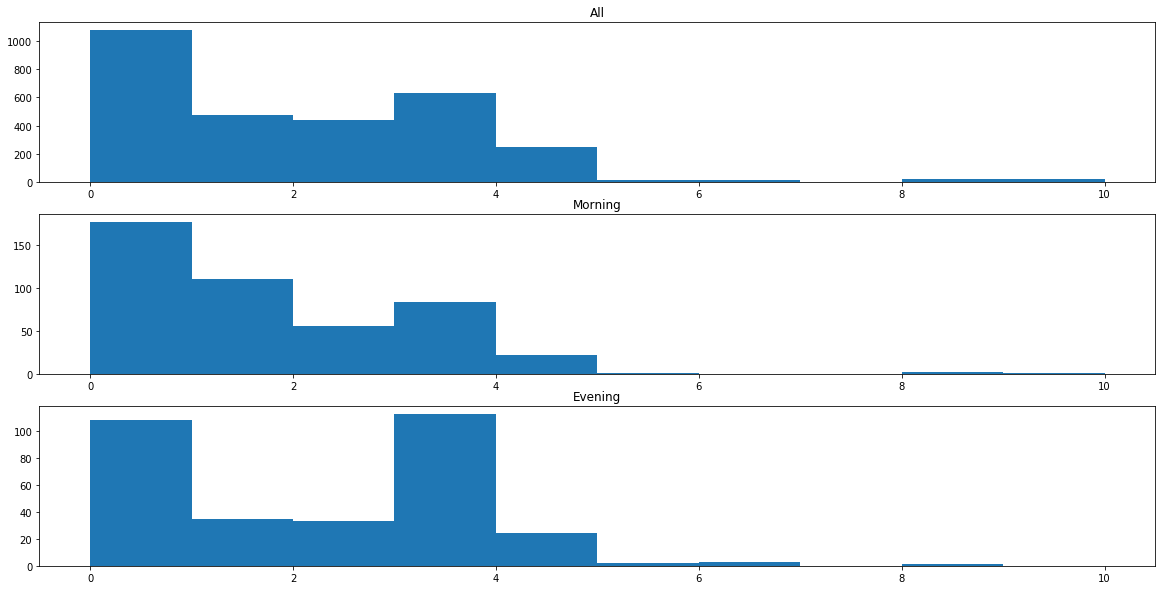

In [14]:
db = DBSCAN(eps=0.00025, min_samples=5)
db.fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=db.labels_, cmap=cm.get_cmap('gist_ncar'));
draw_bars(db.labels_, morning, evening, 10)

This is looking a bit more meaninful, but still contains a lot of points that have been lumped into noise. While we could proceed with a meaningful analysis based on this, tuning our parameters is hard and we can't be sure that this is really optimal. As such, we'll quickly try HDBScan.

### HDBScan

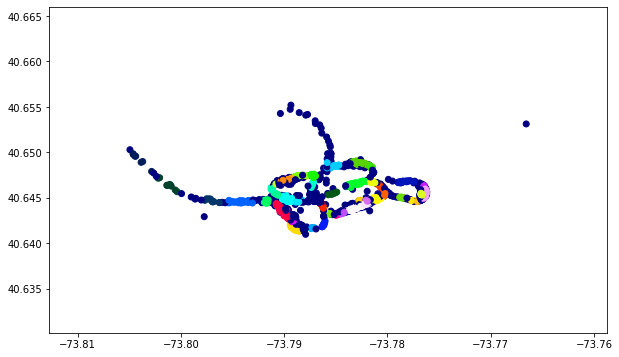

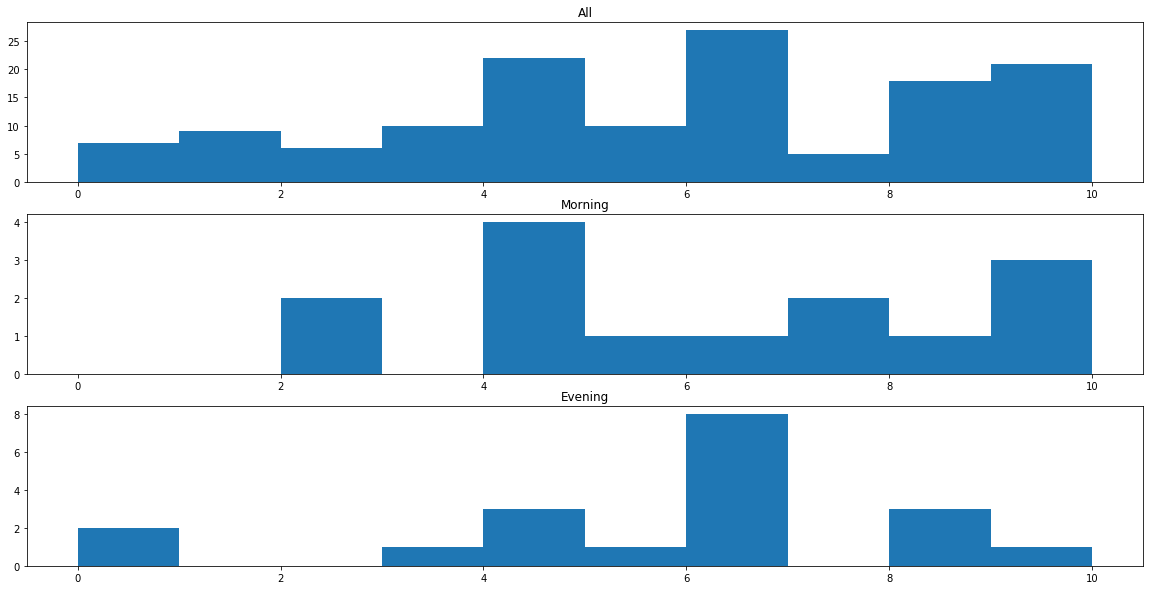

In [15]:
db = HDBSCAN(min_samples=5)
db.fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=db.labels_, cmap=cm.get_cmap('gist_ncar'));
draw_bars(db.labels_, morning, evening, 10)

Whether the above is better than our DBScan results is somewhat subjective, I'd argue that we have too much data in the noise class at the moment (consider the small cluster sizes compared to other methods - all points not clustered are noise).

### Summary

On the whole, we can use any of these for a knowledge discovery type task. One is not necessarily better than the other, as they all have strengths and weaknesses, for example:
* k-means is quick, much quicker than the others
* GMMs give us the soft decision boundaries, and allows us to have clusters of different shapes
* HAC let's us specify the distance between points rather than the number of clusters. This may be really good if we have prior knowledge about the maximum distance that points can be from each other while still being in the same class
* DBScan allows us to pull points out into a noise clusters, however setting the distance threshold is difficult and if we get this wrong, we can either see most points in one cluster, or most points labelled as noise.

## Application 2: Abnormalitiy Detection
For our second application, we'll look at finding abnormal samples within the same data.

Before we do this, we need some sort of definition of abnormal. Typically, we think of something that does not fit the rest of the distribution or the rest of the model as being abnormal - and we'll try and use this idea to find abnormal points using different methods. We'll make the assumption that 0.2% of the points are abnormal, and try find the weirdest 0.2% of things.

In [16]:
abnormal_amount = 0.002;
abnormal_count = int(len(X)*(1.0 - abnormal_amount))

Note that this value has been chosen primarily becuase it will allow us to see those points easily on the plot. If I made this too big, things would get harder to visualise. Ideally, you'd have some sort of threshold or other criteria to determine what is and isn't likely.

### With K-Means
We'll start with K-Means, and our 200 clusters that was the minimum BIC value. To do this we:
* Cluster the data
* Get the distance between each cluster and it's assigned centre
* Find those clusters with the biggest distance to their parent cluster, we'll call these points abnormal

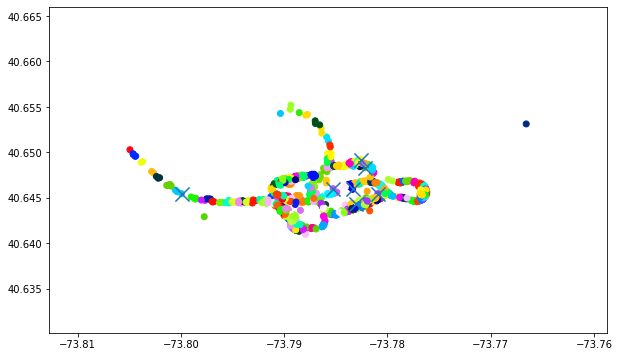

In [17]:
kmeans = KMeans(n_clusters=200, random_state=4).fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap=cm.get_cmap('gist_ncar'));
distances = kmeans.transform(X)
distances = numpy.min(distances, axis=1)
sorted_distances = numpy.argsort(distances)
ax.scatter(X[sorted_distances[abnormal_count:],0], X[sorted_distances[abnormal_count:],1], marker='x', s=200)

This first attempt is pretty poor, and our abnormal points really just exist at cluster boundaries. We'll try again with fewer clusters.

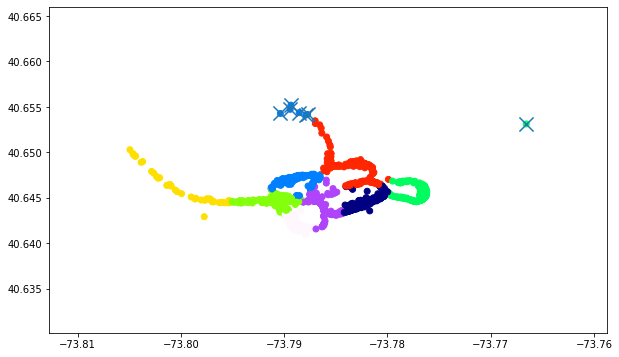

In [18]:
kmeans = KMeans(n_clusters=8, random_state=4).fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap=cm.get_cmap('gist_ncar'));
distances = kmeans.transform(X)
distances = numpy.min(distances, axis=1)
sorted_distances = numpy.argsort(distances)
ax.scatter(X[sorted_distances[abnormal_count:],0], X[sorted_distances[abnormal_count:],1], marker='x', s=200)

This makes a bit more sense. Certainly the point out on the right makes sense. Before this would have been it's own cluster, thus it's distance to it's cluster centre was 0 (it was it's own cluster centre). For the other points, these are all blue points, and so are far from the rest of the cluster. While it's understandable why these points have been grouped as abnormal, are they actually abnormal?

### With a GMM
We'll use a GMM now, and we'll go with the 10 clusters that was suggested by BIC. We'll do this:
* Compute our GMM
* Get the score for each componemt
* Find the set of least likely points

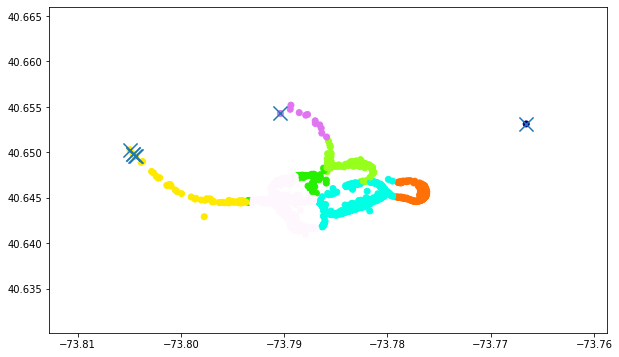

In [19]:
gmm = GaussianMixture(10, random_state=4)
gmm.fit(X)
labels = gmm.predict(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=labels, cmap=cm.get_cmap('gist_ncar'));
scores = gmm.score_samples(X)
sorted_scores = numpy.flip(numpy.argsort(scores))
ax.scatter(X[sorted_scores[abnormal_count:],0], X[sorted_scores[abnormal_count:],1], marker='x', s=200)

This makes more sense than K-means. We're now not just considering distance to the centre point (though in an indirect sense we still are), but consider how likley a point is given the learned distribution. This gives us much greater scope to say if something is usual or unusual.

For completeness, let's look at the GMM with 25 clusters.

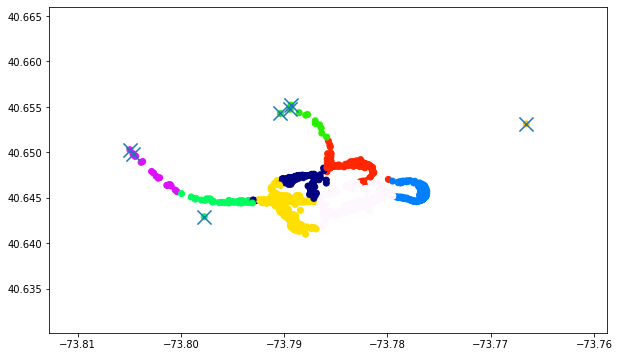

In [20]:
gmm = GaussianMixture(25, random_state=4)
gmm.fit(X)
labels = gmm.predict(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=labels, cmap=cm.get_cmap('gist_ncar'));
scores = gmm.score_samples(X)
sorted_scores = numpy.flip(numpy.argsort(scores))
ax.scatter(X[sorted_scores[abnormal_count:],0], X[sorted_scores[abnormal_count:],1], marker='x', s=200)

What we see if that our clusters have changed (and there ae more of them), but the abnormalities are pretty consistent, which is nice. This suggests that the GMM is somewhat more consistent than KMeans. Could we make K-Means better? Yes, we could consider things like:
* Distance from the cluster centre, however as cluster size changes this could cause problems
* Distance from the cluster centre normalised by cluster size, this would account for cluster size, such that for large clusters points can be further from the centre before being abnormal. There are still issues around cluster shape, but we could normalise both directions, at which point we're starting to model the cluster as a Gaussian anyway.

### With HAC
In the MATLAB version I dodge this bullet, as it really doesn't make sense. There are a number of reasons for this, including:
* We don't have a meaningful distance measure to use. While our dendrogram contains distances, most of these end up being between clusters as merges occur, and so finding "outlier" points in the data doesn't really work
* HAC doesn't fit a typical anomaly detection pipeline. Normally with anomaly detection, we learn a model of what's normal, and then take new data and see how well it fits that model. As HAC builds a tree for clustering, we can add points to the clustering after the fact. With a GMM or K-means we can determine what cluster a point belongs to with minimal impact on the model. With HAC adding a point to cluster potentially changes the whole tree, and all the results.

This doesn't mean HAC isn't a useful method - it just doesn't work for this application.

That said, we did we some interesting behaviour a while ago in Example 4 with single linkage clustering. Single linkage clustering. Let's see what that does here. The problem with using HAC for this is that we need to decide how many clusters we want, or on a distance threhsold. Neither of these is necessarily obvious. We will take the following approach:
* Assume that all of our normal points are going to be nice and tightly packed and thus form 1 cluster
* Assume that all our weird points will be on their own, and thus won't get clustered
* Therefore, we need the number of abnormal points we're expecting + 1 clusters

Text(0.5, 1.0, 'Single')

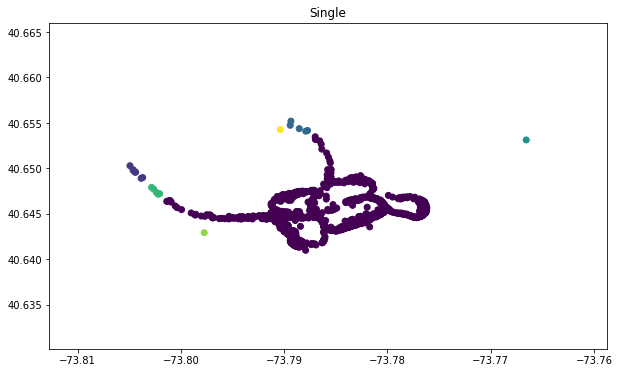

In [21]:
hac = AgglomerativeClustering(n_clusters=int(abnormal_count*abnormal_amount + 1), linkage='single', compute_full_tree=True)
hac = hac.fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Single')

If we change our linkage criteria, this won't work. It only really has a hope for single linkage clustering. Even then, it's not a great option in my opinion. It works here (sort of), but we don't really get an explanation as to why a point is abnormal. With KMeans we have a distance measure, and with the GMM we have a likelihood. For HAC, we do have a distance in the dendrogram, but this is not as intuitive - particularly once we have merged points.

For completeness, here's it failing on complete linkage clustering.

Text(0.5, 1.0, 'Complete')

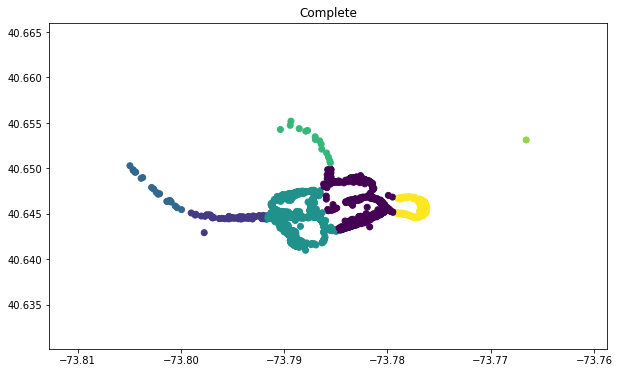

In [22]:
hac = AgglomerativeClustering(n_clusters=int(abnormal_count*abnormal_amount + 1), linkage='complete', compute_full_tree=True)
hac = hac.fit(X)
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Complete')

### With DBScan

For DBScan, anomaly detection doesn't make a lot of sense. The closest we get is the noise cluster - but depending on how our distance measure (and to a lesser extent minimum cluster size is set) we can get way too many points in this set to really consider these points abnormal.

While the noise filtering can be extremely useful, it's not really a great solution for abnormality detection.

## Summary
So what can we draw from this? A few things:
* K means is the quickest, by far. The others can take a while to cluster. Keep in mind that this is only a small dataset too (~3000 samples). While run-time isn't a real bottleneck here, it can become an issue on bigger datasets
* K-means and HAC produce similar looking results, in that clusters don't overlap. 
* GMMs allow clusters to overlap, and to have small dense clusters within larger, sparse clusters. This can be quite useful, and allows the GMM to potentially capture multiple sparse, background type clusters
* While HAC doesn't require you to specify the number of clusters in advance, you stil need to make decisions.
* DBScan can separate noise from other points, but hyper-parameters can be hard to set, and incorrectly setting these can lead to all (or most) points being in one cluster, or all (most?) points being noise
* Posterior distributions allow you to easily work out how likely a point is

With regards to our applications:
* All methods can be used for visualisation. The choice of method probably comes down to the nature of the data, what prior knowledge you have, etc. K-means is nice in it's simplicity, HAC is good in that you can very easily try different numbers of clusters and use a "cut-off" distance if you have this sort of prior knowledge, while the GMM will give you the ability to do soft assignment and capture odd shaped clusters. If you have lots of noise that you wish to ignore, DBScan may be a good choice.
* GMMs have some clear benefits for anomaly detection, the biggest of which is the likelihood measures. HAC has another huge disadvantage for this application in that we can't add clusters to the model after the fact. Usually with anomaly detection, we train and model and then try to find anomalies in new data - which HAC this is not possible. DBScan also is hard to use for anomaly detection.

Ultimatley there is no "one size fits all" method and a number of things should be considered. Keep in mind too that the GMM training actually uses K-means as an initial step, so these approaches can go hand-in-hand. There is also no reason that the GMM needs to use K-means either (though the fact that it's fairly computationally cheap makes it appealing), you could potentially use HAC to make the initial cluster assignments that are then refined via EM.